<a href="https://colab.research.google.com/github/Lingasri/Deepfake-Detection-Project/blob/main/Deepfake_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 37 images belonging to 3 classes.
Found 36 images belonging to 3 classes.
{'.ipynb_checkpoints': 0, 'fake': 1, 'real': 2}
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.4340 - loss: -0.6356
Test Accuracy: 0.4167
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicted likelihood: 0.9408
Actual label: 1
Correct prediction: True


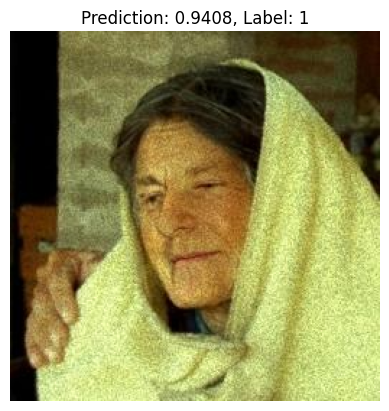

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Height and width refer to the size of the image
# Channels refer to the number of color channels (red, green, blue)
image_dimensions = {'height': 256, 'width': 256, 'channels': 3}

# Create a Classifier class
class Classifier:
    def __init__(self):
        self.model = None

    def predict(self, x):
        return self.model.predict(x)

    def fit(self, x, y):
        return self.model.train_on_batch(x, y)

    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)

    def load(self, path):
        self.model.load_weights(path)

# Create a MesoNet class using the Classifier
class Meso4(Classifier):
    def __init__(self, learning_rate=0.001):
        self.model = self.init_model()
        optimizer = Adam(learning_rate=learning_rate)  # Correct argument usage
        self.model.compile(optimizer=optimizer,
                           loss='binary_crossentropy',  # More appropriate for binary classification
                           metrics=['accuracy'])

    def init_model(self):
        x = Input(shape=(image_dimensions['height'],
                         image_dimensions['width'],
                         image_dimensions['channels']))

        x1 = Conv2D(8, (3, 3), padding='same', activation='relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

        x2 = Conv2D(8, (5, 5), padding='same', activation='relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)

        x3 = Conv2D(16, (5, 5), padding='same', activation='relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)

        x4 = Conv2D(16, (5, 5), padding='same', activation='relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)

        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation='sigmoid')(y)

        return Model(inputs=x, outputs=y)

# Instantiate the MesoNet model with pretrained weights
meso = Meso4()
meso.load('/content/weights/Meso4_DF.h5')

# Create ImageDataGenerators for train and test sets
# Rescaling pixel values (between 0 and 255) to a range between 0 and 1
dataGenerator = ImageDataGenerator(rescale=1./255)

# Train data generator
train_generator = dataGenerator.flow_from_directory(
    '/content/sample_data/train',
    target_size=(image_dimensions['height'], image_dimensions['width']),
    batch_size=32,  # Adjust batch size as needed
    class_mode='binary',
    shuffle=True)

# Test data generator
test_generator = dataGenerator.flow_from_directory(
    '/content/sample_data/test',
    target_size=(image_dimensions['height'], image_dimensions['width']),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

# Checking class indices (real -> 0, fake -> 1)
print(train_generator.class_indices)



# Evaluate the model on the test set
test_loss, test_accuracy = meso.model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Fetch a batch of data from the test set using the next() function
X_test, y_test = next(test_generator)

# Evaluate prediction for the first image in the batch
predicted_likelihood = meso.predict(X_test)[0][0]
actual_label = int(y_test[0])
correct_prediction = round(predicted_likelihood) == actual_label

# Display prediction results
print(f"Predicted likelihood: {predicted_likelihood:.4f}")
print(f"Actual label: {actual_label}")
print(f"Correct prediction: {correct_prediction}")

# Display the first test image
plt.imshow(np.squeeze(X_test[0]))
plt.title(f"Prediction: {predicted_likelihood:.4f}, Label: {actual_label}")
plt.axis('off')  # Hide axis labels
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Predicted confidence: 21.07%
Actual label: 2
Correct prediction: False


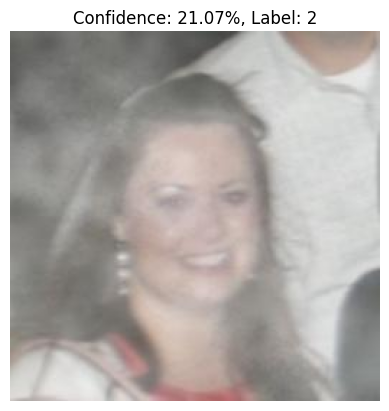

In [8]:
# Fetch a batch of data from the test set using the next() function
X_test, y_test = next(test_generator)

# Evaluate prediction for the first image in the batch
predicted_likelihoods = meso.predict(X_test)  # Get predicted probabilities for the batch
predicted_confidence = predicted_likelihoods[0][0]  # Confidence for the first image
actual_label = int(y_test[0])  # Actual label (0 or 1)

# Calculate confidence level
confidence_level = round(predicted_confidence * 100, 2)  # Convert to percentage
correct_prediction = round(predicted_confidence) == actual_label  # Check if prediction is correct

# Display prediction results
print(f"Predicted confidence: {confidence_level}%")
print(f"Actual label: {actual_label}")
print(f"Correct prediction: {correct_prediction}")

# Display the first test image
plt.imshow(np.squeeze(X_test[0]))
plt.title(f"Confidence: {confidence_level}%, Label: {actual_label}")
plt.axis('off')  # Hide axis labels
plt.show()


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision  # Import the Precision metric

# Height and width refer to the size of the image
image_dimensions = {'height': 256, 'width': 256, 'channels': 3}

# Create a MesoNet class using the Classifier
class Meso4:
    def __init__(self, learning_rate=0.001):
        self.model = self.init_model()
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer,
                           loss='binary_crossentropy',
                           metrics=['accuracy', Precision()])  # Add Precision metric

    def init_model(self):
        x = Input(shape=(image_dimensions['height'],
                         image_dimensions['width'],
                         image_dimensions['channels']))

        x1 = Conv2D(8, (3, 3), padding='same', activation='relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

        x2 = Conv2D(8, (5, 5), padding='same', activation='relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)

        x3 = Conv2D(16, (5, 5), padding='same', activation='relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)

        x4 = Conv2D(16, (5, 5), padding='same', activation='relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)

        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation='sigmoid')(y)

        return Model(inputs=x, outputs=y)

# Instantiate a MesoNet model
meso = Meso4()

# Prepare image data
dataGenerator = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Adding validation split

# Training data generator
train_generator = dataGenerator.flow_from_directory(
    '/content/sample_data/train',  # Folder path for training data
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    subset='training')

# Validation data generator
validation_generator = dataGenerator.flow_from_directory(
    '/content/sample_data/train',  # Same folder, using subset for validation
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    subset='validation')

# Train the model and store the history
history = meso.model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)


Found 31 images belonging to 3 classes.
Found 6 images belonging to 3 classes.
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.1290 - loss: 3.9671 - precision_4: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.5361 - val_precision_4: 1.0000
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2903 - loss: -0.5197 - precision_4: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.3794 - val_precision_4: 1.0000
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3871 - loss: -2.3179 - precision_4: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.2841 - val_precision_4: 1.0000
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4839 - loss: -5.3722 - precision_4: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.2268 - val_precision_4: 1.0000
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4839 - loss: -7.9217 - precision_4: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.2024 - val_precision_4: 1.0000
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4